In [1]:
!pip install tensorflow-model-optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.6/240.6 kB 5.4 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 kB 22.8 MB/s eta 0:00:00


# Necessary Imports

In [2]:
import numpy as np 
import tensorflow as tf
from tensorflow import keras
import glob
import os
import csv
import tempfile
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity
import sys
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import math
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tensorflow_model_optimization.sparsity.keras import UpdatePruningStep
import tensorflow.lite as lite
from tensorflow.lite.python import lite_constants
from tensorflow.keras.models import load_model
import pickle

# Attention Layer Definition (from https://github.com/ludlows/CSI-Activity-Recognition)

In [3]:
class AttenLayer(tf.keras.layers.Layer):
    def __init__(self, num_state, **kw):
        super(AttenLayer, self).__init__(**kw)
        self.num_state = num_state
    
    def build(self, input_shape):
        self.kernel = self.add_weight('kernel', shape=[input_shape[-1], self.num_state])
        self.bias = self.add_weight('bias', shape=[self.num_state])
        self.prob_kernel = self.add_weight('prob_kernel', shape=[self.num_state])

    def call(self, input_tensor):
        atten_state = tf.tanh(tf.tensordot(input_tensor, self.kernel, axes=1) + self.bias)
        logits = tf.tensordot(atten_state, self.prob_kernel, axes=1)
        prob = tf.nn.softmax(logits)
        weighted_feature = tf.reduce_sum(tf.multiply(input_tensor, tf.expand_dims(prob, -1)), axis=1)
        return weighted_feature
    
    # for saving the model
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'num_state': self.num_state,})
        return config

# Original Bi-LSTM Model (from https://github.com/ludlows/CSI-Activity-Recognition)

In [4]:
class CSIModelConfig_original:
    def __init__(self, win_len=1000, step=200, thrshd=0.6, downsample=2):
        self._win_len = win_len
        self._step = step
        self._thrshd = thrshd
        self._labels = ("bed", "fall", "pickup", "run", "sitdown", "standup", "walk")
        self._downsample = downsample

    def preprocessing(self, raw_folder, save=False):
        numpy_tuple = extract_csi(raw_folder, self._labels, save, self._win_len, self._thrshd, self._step)
        if self._downsample > 1:
            return tuple([v[:, ::self._downsample,...] if i%2 ==0 else v for i, v in enumerate(numpy_tuple)])
        return numpy_tuple
    
    def load_csi_data_from_files(self, np_files):
        if len(np_files) != 7:
            raise ValueError('There should be 7 numpy files for bed, fall, pickup, run, sitdown, standup, walk.')
        x = [np.load(f)['arr_0'] for f in np_files]
        if self._downsample > 1:
            x = [arr[:,::self._downsample, :] for arr in x]
        y = [np.zeros((arr.shape[0], len(self._labels))) for arr in x]
        numpy_list = []
        for i in range(len(self._labels)):
            y[i][:,i] = 1
            numpy_list.append(x[i])
            numpy_list.append(y[i])
        return tuple(numpy_list)


    
    def build_model(self, n_unit_lstm=200, n_unit_atten=400):
        if self._downsample > 1:
            length = len(np.ones((self._win_len,))[::self._downsample])
            x_in = tf.keras.Input(shape=(length, 90))
        else:
            x_in = tf.keras.Input(shape=(self._win_len, 90))
        x_tensor = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=n_unit_lstm, return_sequences=True))(x_in)
        x_tensor = AttenLayer(n_unit_atten)(x_tensor)
        pred = tf.keras.layers.Dense(len(self._labels), activation='softmax')(x_tensor)
        model = tf.keras.Model(inputs=x_in, outputs=pred)
        return model
    
    
    @staticmethod
    def load_model(hdf5path):
        """
        Returns the Tensorflow Model for AttenLayer
        Args:
            hdf5path: str, the model file path
        """
        model = tf.keras.models.load_model(hdf5path, custom_objects={'AttenLayer':AttenLayer})
        return model

In [5]:
cfg = CSIModelConfig_original(win_len=1000, step=200, thrshd=0.6, downsample=2)

In [6]:
# define paths to numpy files
x_train_path = '/kaggle/input/inputs-np/x_train.npy'
y_train_path = '/kaggle/input/inputs-np/y_train.npy'
x_valid_path = '/kaggle/input/inputs-np/x_valid.npy'
y_valid_path = '/kaggle/input/inputs-np/y_valid.npy'
x_test_path = '/kaggle/input/inputs-np/x_test.npy'
y_test_path = '/kaggle/input/inputs-np/y_test.npy'

# check if numpy files exist
if os.path.exists(x_train_path) and os.path.exists(y_train_path) and os.path.exists(x_valid_path) and os.path.exists(y_valid_path) and os.path.exists(x_test_path) and os.path.exists(y_test_path):
    # load data from numpy files
    x_train = np.load(x_train_path)
    y_train = np.load(y_train_path)
    x_valid = np.load(x_valid_path)
    y_valid = np.load(y_valid_path)
    x_test = np.load(x_test_path)
    y_test = np.load(y_test_path)
else:
    # read data from npz files
    numpy_tuple = cfg.load_csi_data_from_files(('/kaggle/input/npz-har-csi/x_bed.npz', '/kaggle/input/npz-har-csi/x_fall.npz', '/kaggle/input/npz-har-csi/x_pickup.npz', '/kaggle/input/npz-har-csi/x_run.npz', '/kaggle/input/npz-har-csi/x_sitdown.npz', '/kaggle/input/npz-har-csi/x_standup.npz', '/kaggle/input/npz-har-csi/x_walk.npz'))
    x_bed, y_bed, x_fall, y_fall, x_pickup, y_pickup, x_run, y_run, x_sitdown, y_sitdown, x_standup, y_standup, x_walk, y_walk = numpy_tuple

    # combine data and labels
    x = np.concatenate([x_bed, x_fall, x_pickup, x_run, x_sitdown, x_standup, x_walk])
    y = np.concatenate([y_bed, y_fall, y_pickup, y_run, y_sitdown, y_standup, y_walk])

    # split data into train and test sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=379)

    # split train data into train and validation sets
    x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, stratify=y_train, random_state=379)

    # save data as numpy files
    np.save(x_train_path, x_train)
    np.save(y_train_path, y_train)
    np.save(x_valid_path, x_valid)
    np.save(y_valid_path, y_valid)
    np.save(x_test_path, x_test)
    np.save(y_test_path, y_test)

In [7]:
print(x_train.shape)
print(y_train.shape)
print()
print(x_valid.shape)
print(y_valid.shape)
print()
print(x_test.shape)
print(y_test.shape)

(5098, 500, 90)
(5098, 7)

(567, 500, 90)
(567, 7)

(1417, 500, 90)
(1417, 7)


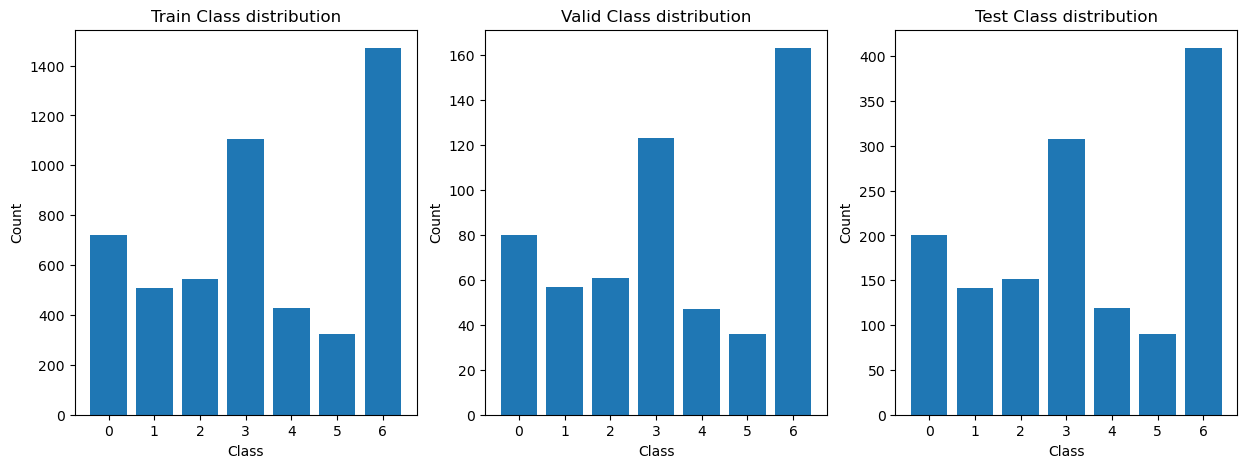

In [14]:
train_classes = np.argmax(y_train, axis=1)
valid_classes = np.argmax(y_valid, axis=1)
test_classes = np.argmax(y_test, axis=1)

# Calculate the number of classes
num_classes = len(np.unique(train_classes))

# Calculate class counts for train, valid, and test sets
train_class_counts = np.zeros(num_classes)
valid_class_counts = np.zeros(num_classes)
test_class_counts = np.zeros(num_classes)

for i in range(num_classes):
    train_class_counts[i] = np.sum(train_classes == i)
    valid_class_counts[i] = np.sum(valid_classes == i)
    test_class_counts[i] = np.sum(test_classes == i)

# Create a figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot the class distribution for y_train
ax1.bar(np.arange(num_classes), train_class_counts)
ax1.set_xlabel('Class')
ax1.set_ylabel('Count')
ax1.set_title('Train Class distribution')

# Plot the class distribution for y_valid
ax2.bar(np.arange(num_classes), valid_class_counts)
ax2.set_xlabel('Class')
ax2.set_ylabel('Count')
ax2.set_title('Valid Class distribution')

# Plot the class distribution for y_test
ax3.bar(np.arange(num_classes), test_class_counts)
ax3.set_xlabel('Class')
ax3.set_ylabel('Count')
ax3.set_title('Test Class distribution')

# Display the figure
plt.show()


In [8]:
cfg = CSIModelConfig_original(win_len=1000, step=200, thrshd=0.6, downsample=2)

In [28]:
model = cfg.build_model(n_unit_lstm=200, n_unit_atten=400)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

model.summary()

history = model.fit(
    x_train,
    y_train,
    batch_size=128, epochs=150,
    validation_data=(x_valid, y_valid),
     callbacks=[
        tf.keras.callbacks.ModelCheckpoint('best_attention.hdf5',
                                            monitor='val_accuracy',
                                            save_best_only=True,
                                            save_weights_only=False),
         tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
        ])

with open('history_bilstm.pkl', 'wb') as f:
    pickle.dump(history.history, f)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 500, 90)]         0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 500, 400)         465600    
 nal)                                                            
                                                                 
 atten_layer_2 (AttenLayer)  (None, 400)               160800    
                                                                 
 dense_2 (Dense)             (None, 7)                 2807      
                                                                 
Total params: 629,207
Trainable params: 629,207
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
40/40 [==============================] - 13s 211ms/step - loss: 1.5584 - accuracy: 0.4188 - val_loss: 1.277

In [30]:
# load the best model
model = cfg.load_model('/kaggle/input/trained-models/best_attention.hdf5')

#load the history
with open('/kaggle/input/trained-models/history_bilstm.pkl', 'rb') as f:
    history = pickle.load(f)

# evaluate on test set
y_pred = model.predict(x_test)

45/45 [==============================] - 2s 37ms/step


In [31]:
print(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

[[188   0   2   0   4   0   6]
 [  0 141   0   0   0   0   0]
 [  0   0 149   0   0   0   2]
 [  0   0   0 306   0   0   1]
 [  2   0   0   0 114   2   1]
 [  0   0   1   0   3  81   5]
 [  0   0   0   0   0   0 409]]


In [32]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96       200
           1       1.00      1.00      1.00       141
           2       0.98      0.99      0.98       151
           3       1.00      1.00      1.00       307
           4       0.94      0.96      0.95       119
           5       0.98      0.90      0.94        90
           6       0.96      1.00      0.98       409

    accuracy                           0.98      1417
   macro avg       0.98      0.97      0.97      1417
weighted avg       0.98      0.98      0.98      1417



**Original Bi-LSTM**

Total Params = 629207

Average Inference Time (for each step) = 37ms

Accuracy = 98%

Model Size(on system) = 7.25 MB

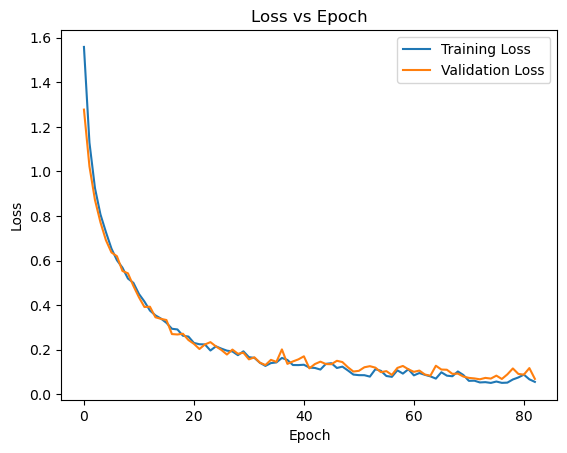

In [33]:
# plot training and validation loss
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')

plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

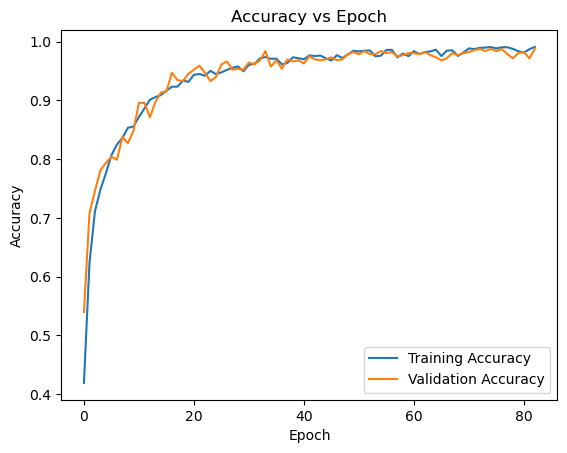

In [36]:
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')

plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Modified Model with Bi-GRU

In [45]:
class CSIModelConfig_BiGRU:
    def __init__(self, win_len=1000, step=200, thrshd=0.6, downsample=2):
        self._win_len = win_len
        self._step = step
        self._thrshd = thrshd
        self._labels = ("bed", "fall", "pickup", "run", "sitdown", "standup", "walk")
        self._downsample = downsample

    def preprocessing(self, raw_folder, save=False):
        numpy_tuple = extract_csi(raw_folder, self._labels, save, self._win_len, self._thrshd, self._step)
        if self._downsample > 1:
            return tuple([v[:, ::self._downsample,...] if i%2 ==0 else v for i, v in enumerate(numpy_tuple)])
        return numpy_tuple
    
    def load_csi_data_from_files(self, np_files):
        if len(np_files) != 7:
            raise ValueError('There should be 7 numpy files for bed, fall, pickup, run, sitdown, standup, walk.')
        x = [np.load(f)['arr_0'] for f in np_files]
        if self._downsample > 1:
            x = [arr[:,::self._downsample, :] for arr in x]
        y = [np.zeros((arr.shape[0], len(self._labels))) for arr in x]
        numpy_list = []
        for i in range(len(self._labels)):
            y[i][:,i] = 1
            numpy_list.append(x[i])
            numpy_list.append(y[i])
        return tuple(numpy_list)


    
    def build_model(self, n_unit_gru=200, n_unit_atten=400):
        if self._downsample > 1:
            length = len(np.ones((self._win_len,))[::self._downsample])
            x_in = tf.keras.Input(shape=(length, 90))
        else:
            x_in = tf.keras.Input(shape=(self._win_len, 90))
        x_tensor = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=n_unit_gru, return_sequences=True))(x_in)
        x_tensor = AttenLayer(n_unit_atten)(x_tensor)
        pred = tf.keras.layers.Dense(len(self._labels), activation='softmax')(x_tensor)
        model = tf.keras.Model(inputs=x_in, outputs=pred)
        return model
    
    
    @staticmethod
    def load_model(hdf5path):
        """
        Returns the Tensorflow Model for AttenLayer
        Args:
            hdf5path: str, the model file path
        """
        model = tf.keras.models.load_model(hdf5path, custom_objects={'AttenLayer':AttenLayer})
        return model

In [46]:
cfg_GRU = CSIModelConfig_BiGRU(win_len=1000, step=200, thrshd=0.6, downsample=2)

In [47]:
model = cfg_GRU.build_model(n_unit_gru=200, n_unit_atten=400)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

model.summary()

history = model.fit(
    x_train,
    y_train,
    batch_size=128, epochs=150,
    validation_data=(x_valid, y_valid),
     callbacks=[
        tf.keras.callbacks.ModelCheckpoint('best_attention_gru.hdf5',
                                            monitor='val_accuracy',
                                            save_best_only=True,
                                            save_weights_only=False),
         tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
        ])

with open('history_bigru.pkl', 'wb') as f:
    pickle.dump(history.history, f)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 500, 90)]         0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 500, 400)         350400    
 nal)                                                            
                                                                 
 atten_layer_3 (AttenLayer)  (None, 400)               160800    
                                                                 
 dense_3 (Dense)             (None, 7)                 2807      
                                                                 
Total params: 514,007
Trainable params: 514,007
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
40/40 [==============================] - 12s 187ms/step - loss: 1.5066 - accuracy: 0.4776 - val_loss: 1.212

In [53]:
# load the best model
model = cfg.load_model('/kaggle/input/trained-models/best_attention_gru.hdf5')

#load the history
with open('/kaggle/input/trained-models/history_bigru.pkl', 'rb') as f:
    history = pickle.load(f)

# evaluate on test set
y_pred = model.predict(x_test)

45/45 [==============================] - 2s 33ms/step


In [54]:
print(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

[[197   0   0   0   2   1   0]
 [  0 141   0   0   0   0   0]
 [  3   0 147   0   1   0   0]
 [  0   0   0 306   0   0   1]
 [  1   1   0   0 114   3   0]
 [  1   0   0   0   1  88   0]
 [  0   0   0   2   0   1 406]]


In [55]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       200
           1       0.99      1.00      1.00       141
           2       1.00      0.97      0.99       151
           3       0.99      1.00      1.00       307
           4       0.97      0.96      0.96       119
           5       0.95      0.98      0.96        90
           6       1.00      0.99      1.00       409

    accuracy                           0.99      1417
   macro avg       0.98      0.98      0.98      1417
weighted avg       0.99      0.99      0.99      1417



# **Bi-GRU**

Total Params = 514007

Average Inference Time (for each step) = 33ms

Accuracy = 99%

Model Size(on system) = 5.93 MB

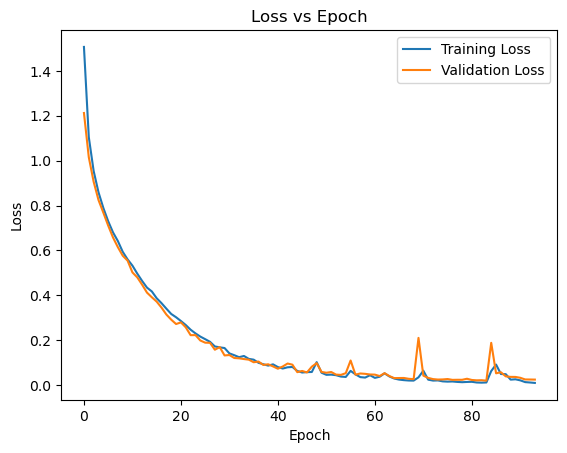

In [51]:
# plot training and validation loss
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')

plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

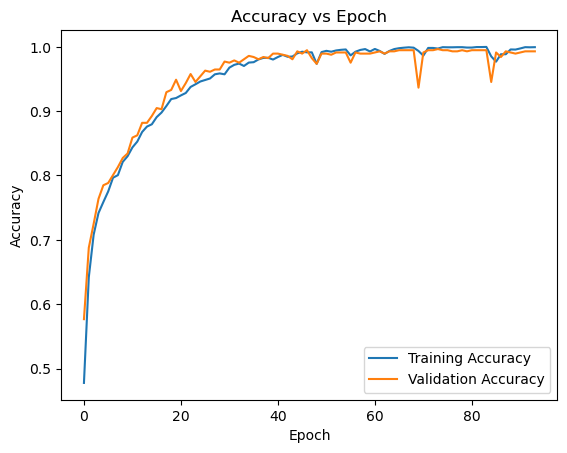

In [52]:
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')

plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Modified Code for CNN with simple GRU (not bidirectional and no Attention Layer also)

In [153]:
class CSIModelConfig_CNNGRU:
    def __init__(self, win_len=1000, step=200, thrshd=0.6, downsample=2):
        self._win_len = win_len
        self._step = step
        self._thrshd = thrshd
        self._labels = ("bed", "fall", "pickup", "run", "sitdown", "standup", "walk")
        self._downsample = downsample

    def preprocessing(self, raw_folder, save=False):
        numpy_tuple = extract_csi(raw_folder, self._labels, save, self._win_len, self._thrshd, self._step)
        if self._downsample > 1:
            return tuple([v[:, ::self._downsample,...] if i%2 ==0 else v for i, v in enumerate(numpy_tuple)])
        return numpy_tuple
    
    def load_csi_data_from_files(self, np_files):
        if len(np_files) != 7:
            raise ValueError('There should be 7 numpy files for bed, fall, pickup, run, sitdown, standup, walk.')
        x = [np.load(f)['arr_0'] for f in np_files]
        if self._downsample > 1:
            x = [arr[:,::self._downsample, :] for arr in x]
        y = [np.zeros((arr.shape[0], len(self._labels))) for arr in x]
        numpy_list = []
        for i in range(len(self._labels)):
            y[i][:,i] = 1
            numpy_list.append(x[i])
            numpy_list.append(y[i])
        return tuple(numpy_list)


    
    def build_model(self, num_filters=64, kernel_size=3, n_unit_gru=150):
        """
        Returns the Tensorflow Model which uses CNN + GRU
        """
        if self._downsample > 1:
            length = len(np.ones((self._win_len,))[::self._downsample])
            x_in = tf.keras.Input(shape=(length, 90))
        else:
            x_in = tf.keras.Input(shape=(self._win_len, 90))
        x_tensor = tf.keras.layers.Conv1D(num_filters, kernel_size, activation='relu')(x_in)
        x_tensor = tf.keras.layers.MaxPooling1D(pool_size=2)(x_tensor)
        x_tensor = tf.keras.layers.GRU(units=n_unit_gru, return_sequences=False)(x_tensor)
        pred = tf.keras.layers.Dense(len(self._labels), activation='softmax')(x_tensor)
        model = tf.keras.Model(inputs=x_in, outputs=pred)
        return model
    
    
    @staticmethod
    def load_model(hdf5path):
        """
        Returns the Tensorflow Model for AttenLayer
        Args:
            hdf5path: str, the model file path
        """
        model = tf.keras.models.load_model(hdf5path, custom_objects={'AttenLayer':AttenLayer})
        return model

In [154]:
cfg_CNNGRU = CSIModelConfig_CNNGRU(win_len=1000, step=200, thrshd=0.6, downsample=2)

In [155]:
model = cfg_CNNGRU.build_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

model.summary()

history = model.fit(
    x_train,
    y_train,
    batch_size=128, epochs=150,
    validation_data=(x_valid, y_valid),
     callbacks=[
        tf.keras.callbacks.ModelCheckpoint('best_attention_cnngru.hdf5',
                                            monitor='val_accuracy',
                                            save_best_only=True,
                                            save_weights_only=False),
         tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
        ])

with open('history_cnngru.pkl', 'wb') as f:
    pickle.dump(history.history, f)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500, 90)]         0         
                                                                 
 conv1d (Conv1D)             (None, 498, 64)           17344     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 249, 64)          0         
 )                                                               
                                                                 
 gru (GRU)                   (None, 150)               97200     
                                                                 
 dense (Dense)               (None, 7)                 1057      
                                                                 
Total params: 115,601
Trainable params: 115,601
Non-trainable params: 0
_______________________________________________________

In [156]:
# load the best model
model = cfg.load_model('/kaggle/input/trained-models/best_attention_cnngru.hdf5')
#load the history
with open('/kaggle/input/trained-models/history_cnngru.pkl', 'rb') as f:
    history = pickle.load(f)

# evaluate on test set
y_pred = model.predict(x_test)

45/45 [==============================] - 1s 9ms/step


In [157]:
print(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

[[194   3   3   0   0   0   0]
 [  0 140   1   0   0   0   0]
 [  3   0 147   0   0   0   1]
 [  0   0   0 304   0   1   2]
 [  2   0   1   0 115   0   1]
 [  2   0   4   0   6  78   0]
 [  1   0   0   0   0   0 408]]


In [158]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       200
           1       0.98      0.99      0.99       141
           2       0.94      0.97      0.96       151
           3       1.00      0.99      1.00       307
           4       0.95      0.97      0.96       119
           5       0.99      0.87      0.92        90
           6       0.99      1.00      0.99       409

    accuracy                           0.98      1417
   macro avg       0.97      0.97      0.97      1417
weighted avg       0.98      0.98      0.98      1417



# **CNN-GRU**

Total Params = 230239

Average Inference Time (for each step) = 9ms

Accuracy = 98%

Model Size(on system) = 1.36 MB

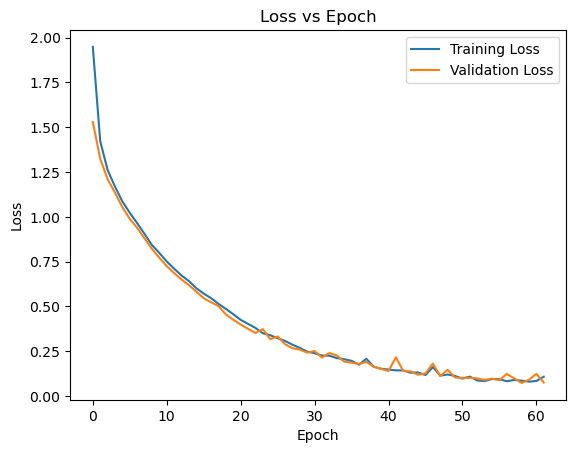

In [50]:
# plot training and validation loss
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')

plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

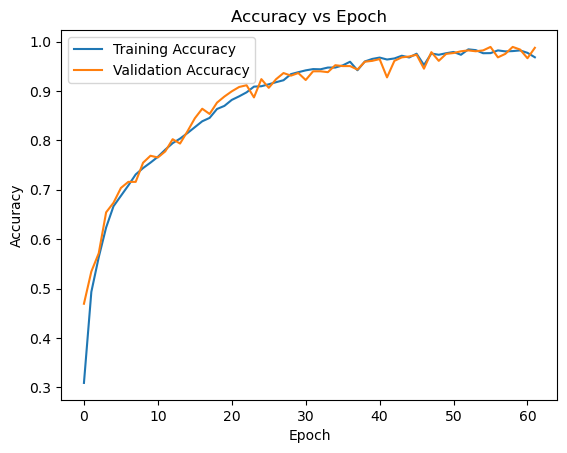

In [51]:
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')

plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [10]:
cfg_CNNGRU = CSIModelConfig_CNNGRU(win_len=1000, step=200, thrshd=0.6, downsample=2)

In [11]:
model = cfg_CNNGRU.load_model('/kaggle/input/trained-models/best_attention_cnngru.hdf5')

# Using the CNN-GRU model and fine-tuning after adding pruning 

In [12]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 60 epochs.
batch_size = 128
epochs = 60

x_shape = x_train.shape[0]
end_step = np.ceil(x_shape / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.20,
                                                               final_sparsity=0.50,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)

model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model_for_pruning.summary()



Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 500, 90)]         0         
                                                                 
 prune_low_magnitude_conv1d_  (None, 498, 64)          34626     
 5 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_max_poo  (None, 249, 64)          1         
 ling1d_5 (PruneLowMagnitude                                     
 )                                                               
                                                                 
 prune_low_magnitude_gru_5 (  (None, 150)              193503    
 PruneLowMagnitude)                                              
                                                                 
 prune_low_magnitude_dense_5  (None, 7)                2109

In [13]:
y_train_flat = np.argmax(y_train, axis=1)
y_valid_flat = np.argmax(y_valid, axis=1)
y_test_flat = np.argmax(y_test,axis=1)

In [14]:
logdir = tempfile.mkdtemp()

callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
]

history = model_for_pruning.fit(
    x_train,
    y_train_flat,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_valid, y_valid_flat),
    callbacks=callbacks
)
with open('history_cnngru_prune.pkl', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/60
40/40 [==============================] - 16s 67ms/step - loss: 1.1149 - accuracy: 0.6322 - val_loss: 0.8082 - val_accuracy: 0.7302
Epoch 2/60
40/40 [==============================] - 2s 48ms/step - loss: 0.6923 - accuracy: 0.7750 - val_loss: 0.6271 - val_accuracy: 0.8289
Epoch 3/60
40/40 [==============================] - 2s 44ms/step - loss: 0.5897 - accuracy: 0.8182 - val_loss: 0.5148 - val_accuracy: 0.8183
Epoch 4/60
40/40 [==============================] - 2s 44ms/step - loss: 0.4868 - accuracy: 0.8541 - val_loss: 0.4416 - val_accuracy: 0.8748
Epoch 5/60
40/40 [==============================] - 2s 44ms/step - loss: 0.3990 - accuracy: 0.8784 - val_loss: 0.4858 - val_accuracy: 0.8448
Epoch 6/60
40/40 [==============================] - 2s 45ms/step - loss: 0.3423 - accuracy: 0.8980 - val_loss: 0.2404 - val_accuracy: 0.9383
Epoch 7/60
40/40 [==============================] - 2s 43ms/step - loss: 0.2746 - accuracy: 0.9188 - val_loss: 0.2614 - val_accuracy: 0.9206
Epoch 8/60
4

In [15]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
pruned_keras_file = 'best_attention_cnngru_prune.hdf5'
tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)

In [16]:
model = cfg.load_model('/kaggle/input/trained-models/best_attention_cnngru_prune.hdf5')
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 500, 90)]         0         
                                                                 
 conv1d_5 (Conv1D)           (None, 498, 64)           17344     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 249, 64)          0         
 1D)                                                             
                                                                 
 gru_5 (GRU)                 (None, 150)               97200     
                                                                 
 dense_5 (Dense)             (None, 7)                 1057      
                                                                 
Total params: 115,601
Trainable params: 115,601
Non-trainable params: 0
_____________________________________________________

In [142]:
y_pred = model.predict(x_test)

45/45 [==============================] - 0s 7ms/step


In [18]:
print(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

[[197   0   3   0   0   0   0]
 [  0 141   0   0   0   0   0]
 [  0   0 147   0   1   3   0]
 [  0   0   0 305   0   0   2]
 [  1   0   0   0 117   0   1]
 [  2   0   0   0   1  87   0]
 [  0   0   0   1   1   0 407]]


In [19]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       200
           1       1.00      1.00      1.00       141
           2       0.98      0.97      0.98       151
           3       1.00      0.99      1.00       307
           4       0.97      0.98      0.98       119
           5       0.97      0.97      0.97        90
           6       0.99      1.00      0.99       409

    accuracy                           0.99      1417
   macro avg       0.99      0.99      0.99      1417
weighted avg       0.99      0.99      0.99      1417



# **CNN-GRU-Pruned**

Total Params = 115601

Average Inference Time (for each step) = 7ms

Accuracy = 99%

Model Size(on system) = 471 KB

In [61]:
model = cfg.load_model('/kaggle/input/trained-models/best_attention_cnngru_prune.hdf5')

# Attempt to Fully Quantize the Weights to UINT8

In [62]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

def quantize_weights(weights, num_bits):
    qmin = -2**(num_bits - 1)
    qmax = 2**(num_bits - 1) - 1
    q_weights = []
    for w in weights:
        scale = np.max(np.abs(w)) / (qmax - qmin)
        zero_point = np.round((qmax + qmin) / 2)
        q_w = np.round(w / scale) + zero_point
        q_w = np.clip(q_w, qmin, qmax)
        q_w = np.round(q_w).astype(np.int8)
        q_w = (q_w - zero_point) * scale
        q_weights.append(q_w)
    return q_weights, scale, zero_point

def load_quantized_model(model_file, num_bits):
    q_weights, scale, zero_point = quantize_weights(model.get_weights(), num_bits)
    model.set_weights(q_weights)
    return model, scale, zero_point

# example usage
model_file = model
num_bits = 8
quantized_model, scale, zero_point = load_quantized_model(model_file, num_bits)

In [63]:
test_data = x_test # load your test data here
test_labels = y_test # load your test labels here
quantized_model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
y_pred = quantized_model.predict(x_test)
from sklearn.metrics import confusion_matrix
print(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

45/45 [==============================] - 1s 8ms/step
[[156   0   5   0  39   0   0]
 [ 17  97  18   0   0   0   9]
 [  0   0 151   0   0   0   0]
 [  0   0   0 251   0   0  56]
 [  3   0   1   0 109   0   6]
 [  2   0   3   0   5  80   0]
 [  0   0   0   1   0   0 408]]


In [64]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.88      0.78      0.83       200
           1       1.00      0.69      0.82       141
           2       0.85      1.00      0.92       151
           3       1.00      0.82      0.90       307
           4       0.71      0.92      0.80       119
           5       1.00      0.89      0.94        90
           6       0.85      1.00      0.92       409

    accuracy                           0.88      1417
   macro avg       0.90      0.87      0.87      1417
weighted avg       0.90      0.88      0.88      1417



# **Fully Quantized Weights for CNN-GRU-Pruned**

Accuracy = 88%

Significant Drop from previous accuracies

Hence full quantization not possible

In [104]:
original_model = '/kaggle/input/trained-models/best_attention_cnngru.hdf5'

In [105]:
model = cfg.load_model('/kaggle/input/trained-models/best_attention_cnngru_prune.hdf5')

In [106]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
    import os
    import zipfile

    _, zipped_file = tempfile.mkstemp('.zip')
    with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(file)

    return os.path.getsize(zipped_file)

# Using Tensorflow to perform Partial Quantization and converting the model to a TFLite model

(TensorFlow Lite is a form of compressed and faster model that enables on-device machine learning)

In [110]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]
quantized_and_pruned_tflite_model = converter.convert()

quantized_and_pruned_tflite_file = 'final_model.tflite'

with open(quantized_and_pruned_tflite_file, 'wb') as f:
    f.write(quantized_and_pruned_tflite_model)

print('Saved quantized and pruned TFLite model to:', quantized_and_pruned_tflite_file)
baseline = get_gzipped_model_size(original_model)
quantized_pruned = get_gzipped_model_size(quantized_and_pruned_tflite_file)
print("Size of baseline Keras model: %.2f bytes" % (baseline))
print("Size of pruned and quantized TFlite model: %.2f bytes" % (quantized_pruned))
print("Percentage of Original: %.2f percent" %((quantized_pruned/baseline)*100))

Saved quantized and pruned TFLite model to: final_model.tflite
Size of baseline Keras model: 1289562.00 bytes
Size of pruned and quantized TFlite model: 78735.00 bytes
Percentage of Original: 6.11 percent


In [144]:
def evaluate_model(interpreter):
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    # Run predictions on every image in the "test" dataset.
    prediction_digits = []
    inference_times = []  # to store inference times for each image
    
    for i, test in enumerate(x_test):
        test = np.expand_dims(test, axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, test)

        # Measure inference time
        start_time = time.time()
        interpreter.invoke()
        end_time = time.time()
        inference_time = end_time - start_time
        inference_times.append(inference_time)

        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])
        prediction_digits.append(digit)

    print('\n')
    prediction_digits = np.array(prediction_digits)
    inference_times = np.array(inference_times)
    return prediction_digits, inference_times

In [146]:
interpreter = tf.lite.Interpreter(model_path='/kaggle/input/trained-models/final_model.tflite')
interpreter.allocate_tensors()

y_pred,inference_times = evaluate_model(interpreter)

In [150]:
print('Average Inference Time:',np.array(inference_times).mean()*100,'ms')

Average Inference Time: 1.2289692839014756 ms


In [148]:
print(confusion_matrix(np.argmax(y_test, axis=1), y_pred))

[[197   0   3   0   0   0   0]
 [  0 141   0   0   0   0   0]
 [  0   0 148   0   0   3   0]
 [  0   0   0 305   0   0   2]
 [  1   0   0   0 116   1   1]
 [  2   0   0   0   1  87   0]
 [  0   0   0   1   1   0 407]]


In [149]:
print(classification_report(np.argmax(y_test, axis=1), y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       200
           1       1.00      1.00      1.00       141
           2       0.98      0.98      0.98       151
           3       1.00      0.99      1.00       307
           4       0.98      0.97      0.98       119
           5       0.96      0.97      0.96        90
           6       0.99      1.00      0.99       409

    accuracy                           0.99      1417
   macro avg       0.98      0.99      0.98      1417
weighted avg       0.99      0.99      0.99      1417



# **CNN-GRU-Pruned-pQuantized(Tflite)**

Total Params = 115601

Average Inference Time (for each step) = 1.22ms

Accuracy = 99%

Model Size(on system) = 131 KB

#  **Result Comparison**

| Model Name        | Total Params | Average Inference Time (per step) | Accuracy | Model Size (on system) |
|------------------|--------------|----------------------------------|----------|------------------------|
| Original Bi-LSTM | 629207       | 37 ms                            | 98%      | 7.25 MB                |
| Bi-GRU           | 514007       | 33 ms                            | 99%      | 5.93 MB                |
| CNN-GRU          | 230239       | 9 ms                             | 98%      | 1.36 MB                |
| CNN-GRU-Pruned   | 115601       | 7 ms                             | 99%      | 471 KB                 |
| CNN-GRU-Pruned-pQuantized(TFLite) | 115601 | 1.22 ms                | 99%      | 131 KB                 |